# Imports

In [1]:
import torch
import paths
import itertools
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix

## Use GPU for inference if available

In [2]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

## Loading our trained model

In [3]:
model = torch.load(paths.MODEL_PATH, map_location=device)

### Apply necessary transformations for resnet18 model.

In [4]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.Resize(256),
    transforms.CenterCrop(224),                       # Resize to fit ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ResNet
])

## Creating the data loader for the test data. 
###  Normally we can use the ImageFolder class provided by torchvision. But in our case we also need to keep track of the image name because we ae going to report predictions for each image. The following cell modifies the behavior or the ImageFolder class to make it track the image name.

In [5]:
class CustomImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(CustomImageFolder, self).__getitem__(index)
        path, _ = self.imgs[index]
        return (Path(path).name, *original_tuple)
    
# Load the dataset
test_dataset = CustomImageFolder(root=paths.TEST_DIR, transform=transform)

# Dataloader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

## Inference loop

In [6]:
# Testing the model
all_labels = []
all_preds = []
all_probs = []
all_ids = []
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for image_ids, images, labels in tqdm(test_loader, desc='Generating predictions'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())
        all_ids.extend(image_ids)
        

    print(f'Accuracy of the model on test images: {100 * correct / total}%')


Generating predictions:   0%|          | 0/16 [00:00<?, ?it/s]

Accuracy of the model on test images: 99.09638554216868%


## Confusion matrix

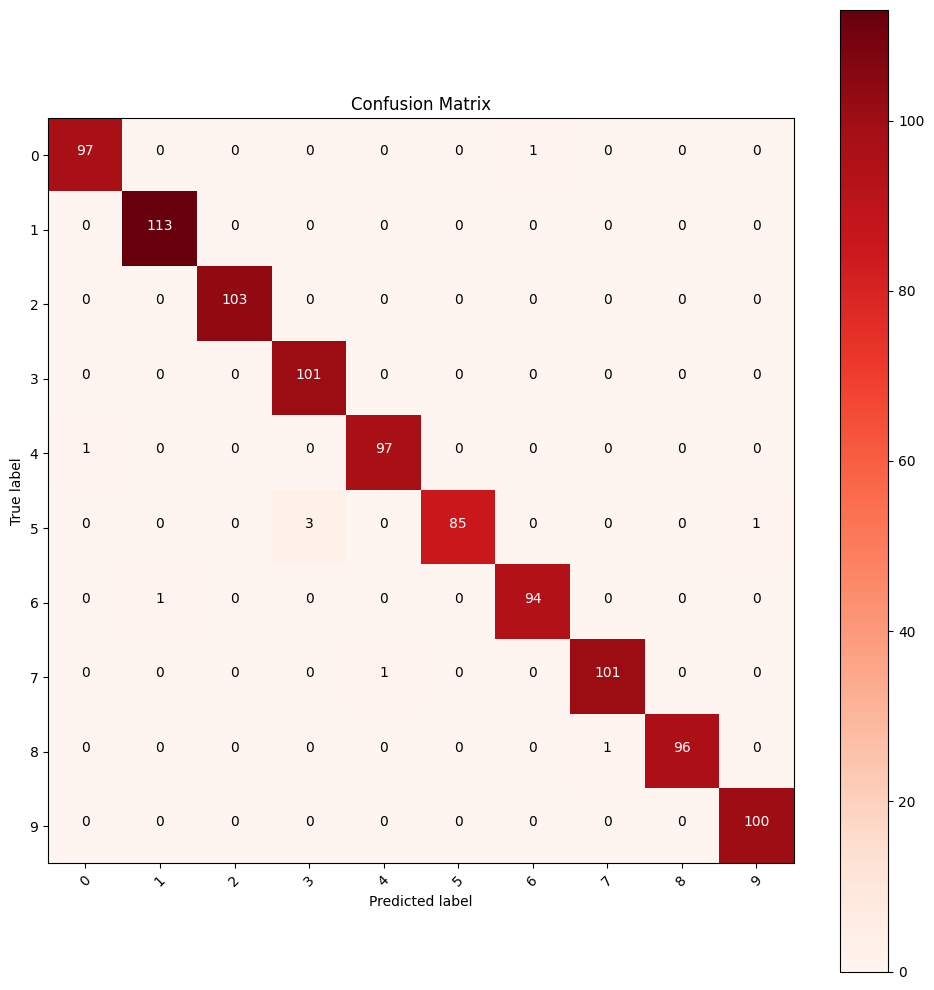

In [7]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optionally: Plot the confusion matrix using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_loader.dataset.classes))
plt.xticks(tick_marks, test_loader.dataset.classes, rotation=45)
plt.yticks(tick_marks, test_loader.dataset.classes)

# Labeling the plot
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## Create predictions dataframe

In [8]:
all_probs = np.array(all_probs)
predictions_df = pd.DataFrame(all_probs, columns=test_loader.dataset.classes)
predictions_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.999950,1.067906e-09,3.258218e-08,2.391526e-09,5.247227e-10,9.074454e-07,0.000029,4.270353e-10,0.000017,0.000002
1,0.999787,9.085519e-09,1.103629e-05,5.615597e-08,1.133832e-07,8.350436e-06,0.000097,5.669732e-08,0.000040,0.000056
2,0.999991,6.432957e-09,1.463841e-07,4.715087e-09,2.700699e-09,5.907522e-07,0.000003,6.521653e-08,0.000002,0.000005
3,0.999974,3.890010e-10,4.220324e-08,7.937996e-10,4.767258e-10,3.813354e-07,0.000019,2.519856e-10,0.000005,0.000002
4,0.999982,6.029012e-09,8.226662e-08,2.222832e-09,1.261349e-09,2.669188e-07,0.000004,3.078321e-08,0.000002,0.000012


## Adding the image name and final prediction to the dataframe

In [9]:
predictions_df.insert(0, 'id', all_ids)
predictions_df['prediction'] = all_labels
predictions_df['prediction'] = predictions_df['prediction'].astype(str).map(test_loader.dataset.class_to_idx)
predictions_df.head()

,id,0,1,2,3,4,5,6,7,8,9,prediction
0,1009.jpg,0.999950,1.067906e-09,3.258218e-08,2.391526e-09,5.247227e-10,9.074454e-07,0.000029,4.270353e-10,0.000017,0.000002,0
1,1047.jpg,0.999787,9.085519e-09,1.103629e-05,5.615597e-08,1.133832e-07,8.350436e-06,0.000097,5.669732e-08,0.000040,0.000056,0
2,1188.jpg,0.999991,6.432957e-09,1.463841e-07,4.715087e-09,2.700699e-09,5.907522e-07,0.000003,6.521653e-08,0.000002,0.000005,0
3,1271.jpg,0.999974,3.890010e-10,4.220324e-08,7.937996e-10,4.767258e-10,3.813354e-07,0.000019,2.519856e-10,0.000005,0.000002,0
4,1590.jpg,0.999982,6.029012e-09,8.226662e-08,2.222832e-09,1.261349e-09,2.669188e-07,0.000004,3.078321e-08,0.000002,0.000012,0


## Save predictions

In [10]:
predictions_df.to_csv(paths.PREDICTIONS_PATH, index=False, float_format="%.6f")